In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
import os
import pickle
# Ensure to set the correct CUDA device if multiple GPUs are available
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
models = ["pretrained_SecBert", "SecBert_E5", "pretrained_SecureBert",  "SecureBert_E5", "pretrained_Gpt2","Gpt2_E5"]
# models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]
#models = ["pretrained_SecBert","pretrained_SecureBert","pretrained_Gpt2"]
current_model = models[5]
sample = 4
margin1=1.0
margin2=1.0
two_losses = True
dir_name = "../../ics_cwe/"+current_model+"/"
# Assuming predefined weights are stored in a numpy array named 'predefined_embeddings1_weights'
text_embeddings = np.load(dir_name+'data/all_embeddings.npy')
with open('../../ics_cwe/id_to_pos.json') as fp:
    id_to_pos = json.load(fp)
with open('../../ics_cwe/pos_to_id.json') as fp:
    pos_to_id = json.load(fp)
graph_path = "../../graph_network/data/"
with open(graph_path+'combined_nodes.json') as fp:
    nodes_json = json.load(fp)
# with open(graph_path+'combined_edges.json') as fp:
#     edges_json = json.load(fp)
# SemiSupervised
with open(graph_path+'combined_edges.json') as fp:
    edges_json = json.load(fp)

with open(dir_name+'data/anchor_pos_neg_triple_{}.pkl'.format(sample), 'rb') as f:
    anchor_pos_neg_triple=pickle.load(f)
nn_dir = dir_name+'data/sample_{}/GCN_embeddings_graph/'.format(sample)
if not os.path.exists(nn_dir):
    os.makedirs(nn_dir)
if(two_losses):
    out_file = '/node_embeddings_gm_{}_tm_{}.npy'.format(margin1, margin2)
else:
    out_file = '/node_embeddings_gm_{}.npy'.format(margin1)

In [3]:
attack_range = (0,203)
weak_range = (203,1136)

In [4]:
anchor_nodes = []
positive_nodes = []
negative_nodes = []
for a,p,n in anchor_pos_neg_triple:
    anchor_nodes.append(a)
    positive_nodes.append(p)
    negative_nodes.append(n)

In [5]:
node_list = list(range(0, weak_range[1]))

In [6]:
edge_list = [(int(e[0]), int(e[1])) for e in edges_json]

In [7]:
import networkx as nx
G = nx.from_edgelist(edge_list)

In [37]:
# Create Graph Features using node2vec
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = np.array([model.wv[str(n)] for n in G.nodes()])

Computing transition probabilities:   0%|          | 0/1136 [00:00<?, ?it/s]


Generating walks (CPU: 4): 100%|██████████| 25/25 [00:01<00:00, 13.76it/s]

In [38]:
np.save(graph_path+'graph_features/node2vec.npy', embeddings)

In [11]:
# Create Graph Features using deepwalk
# Train DeepWalk model
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
from gensim.models import Word2Vec
# Extract Structural Features
degrees = np.array([G.degree(n) for n in G.nodes()])
# Generate Random Walks for DeepWalk
def generate_random_walks(G, num_walks, walk_length):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                neighbors = list(G.neighbors(cur))
                if len(neighbors) > 0:
                    next_node = np.random.choice(neighbors)
                    walk.append(next_node)
                else:
                    break
            walks.append(walk)
    return walks
# Parameters for DeepWalk
num_walks = 200
walk_length = 30
walks = generate_random_walks(G, num_walks, walk_length)

# Train Word2Vec model on walks
walks = [[str(node) for node in walk] for walk in walks]
model = Word2Vec(sentences=walks, vector_size=256, window=5, min_count=0, sg=1, workers=4, epochs=10)

# Extract embeddings
node_ids = list(G.nodes())
embeddings_array = np.array([model.wv[str(node)] for node in node_ids])

In [12]:
embeddings_array.shape
np.save(graph_path+'graph_features/deepwalk.npy', embeddings_array)

In [39]:
node2vec_emb = embeddings
deepwalk_emb = embeddings_array

In [40]:

attack_range = (0,203)
weak_range = (203,1136)
# Generate embeddings for both sets of nodes
attack_nodes = list(range(attack_range[0],attack_range[1]))
weakness_nodes = list(range(weak_range[0],weak_range[1]))
attack_embeddings = node2vec_emb[attack_nodes]
weakness_embeddings = node2vec_emb[weakness_nodes]

In [41]:
# Compute cosine similarity between all pairs of nodes
weak_attack_matrix = cosine_similarity(weakness_embeddings, attack_embeddings)
# Compute cosine similarity between all pairs of nodes
attack_weak_matrix = cosine_similarity(attack_embeddings, weakness_embeddings)

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def histogram2(attack_weak_matrix):
    # print(len(cosine_sim_pairs))
    # print(len(cosine_sim_pairs[0]))
    # for row in cosine_sim_pairs:
    #     print(row[0][1], row[1][1])
    #Extract the cosine similarity values from the filtered results
    #cosine_sim_values = [pair[1] for row in cosine_sim_pairs for pair in row[-30:]]
    cosine_sim_values=[]
    for i in range(len(attack_weak_matrix)):
        for j in range(len(attack_weak_matrix[0])):
            cosine_sim_values.append(attack_weak_matrix[i][j])
    #print(cosine_sim_values)
    # Define the bins for the histogram
    bins = np.arange(0, 1.1, 0.05)  # Bins from 0 to 1 with step size 0.1
    
    # Create the histogram
    plt.hist(cosine_sim_values, bins=bins, edgecolor='black')
    
    # Set the x-axis and y-axis labels
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    
    # Set the title of the histogram
    plt.title('Attack & Weak Positive')
    # plt.savefig(dir2+'/histogram_pos_t_40.png',dpi=300)
    # Show the plot
    plt.show()

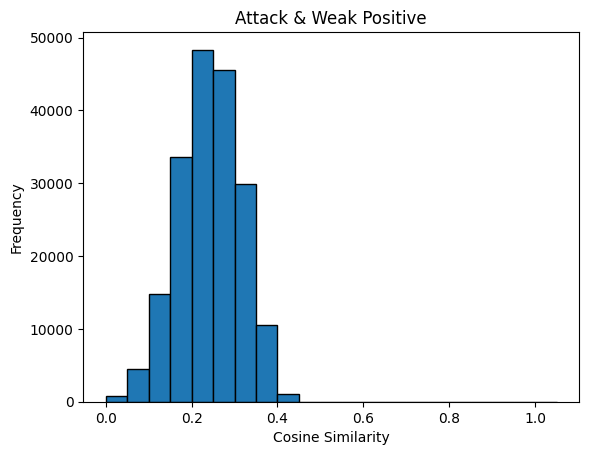

In [43]:
histogram2(attack_weak_matrix)

In [44]:
def get_anchor_pos_neg(positive_threshold,negative_threshold):
    anchor_pos_pair = []
    anchor_neg_pair = []
    # positive_threshold = 0.65  # Similarity threshold for positive pairs
    # negative_threshold = 0.45  # Similarity threshold for negative pairs
    for i, attack_node in enumerate(attack_nodes):
        for j, weakness_node in enumerate(weakness_nodes):
            if attack_weak_matrix[i, j] > positive_threshold:
                anchor_pos_pair.append((attack_node,weakness_node, attack_weak_matrix[i, j]))
            if attack_weak_matrix[i, j] < negative_threshold:
                anchor_neg_pair.append((attack_node,weakness_node, attack_weak_matrix[i, j]))
            
    for i, weakness_node in enumerate(weakness_nodes):
        for j, attack_node in enumerate(attack_nodes):
            if weak_attack_matrix[i, j] > positive_threshold:
                anchor_pos_pair.append((weakness_node,attack_node, weak_attack_matrix[i, j]))
            if weak_attack_matrix[i, j] < negative_threshold:
                anchor_neg_pair.append((weakness_node,attack_node, weak_attack_matrix[i, j]))
    
    anchor_pos_pair.sort(reverse=True, key=lambda x:x[2])
    anchor_neg_pair.sort(key=lambda x:x[2])
    print(len(anchor_pos_pair))
    print(len(anchor_neg_pair))
    anchor_pos_neg_triple = []
    anchor_for_neg = [pair[0] for pair in anchor_neg_pair]
    pos_pair = []
    neg_pair = []
    for anchor,pos,val in anchor_pos_pair:
        if(anchor in anchor_for_neg):
            idx = anchor_for_neg.index(anchor)
            anchor_pos_neg_triple.append((anchor,pos,anchor_neg_pair[idx][1]))
            pos_pair.append((pos,val))
            neg_pair.append((anchor_neg_pair[idx][1],anchor_neg_pair[idx][2]))
            anchor_for_neg.pop(idx)
            anchor_neg_pair.pop(idx)
    return anchor_pos_neg_triple

In [45]:
anchor_pos_neg_triple=get_anchor_pos_neg(positive_threshold=0.30,negative_threshold=0.15)

83238
40514


In [46]:
ass = set()
ps=set()
ns=set()
for a,p,n in anchor_pos_neg_triple:
    ass.add(a)
    ps.add(p)
    ns.add(n)
print(len(ass))
print(len(ps))
print(len(ns))

676
774
892


In [47]:
import pickle
with open(graph_path+'graph_features/anchor_pos_neg_triple_4_node2vec.npy', 'wb') as f:
    pickle.dump(anchor_pos_neg_triple, f)